# 데이콘 Basic Summer
## 쇼핑몰 지점별 매출액 예측 경진대회 

# I. 데이터 살펴보기
## 1. 데이터 준비

In [ ]:
#코랩 구글 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 사용할 라이브러리 불러오기
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

from sklearn.svm import LinearSVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge,RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dropout

from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional

In [ ]:
# train 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/train.csv')

# test 데이터 불러오기
test = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/test.csv')

# sample_submission 불러오기
sample_submission = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/sample_submission.csv')

In [ ]:
# 잘 불러와졌는지 확인합니다.
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


## 2. 데이터 확인

이제 데이터가 어떻게 생겼는지 살펴봅시다.

처음 데이터를 살펴 볼 때에는 pandas의 **head()**, **tail()** 그리고 **info()** 메소드를 활용하여 데이터를 살펴보는 경우가 많습니다.

이는 데이터와 처음과 끝을 살펴봄으로서, **이상치나 결측치**와 같은 데이터를 살펴보기 위함입니다.

In [15]:
# 데이터를 살펴보기 위해 데이터 최상단의 5줄을 표시합니다.
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [16]:
# 데이터를 살펴보기 위해 데이터 최하단의 5줄을 표시합니다.
train.tail()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20
6254,6255,45,28/09/2012,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,8.684,False,713173.95


데이터 칼럼을 살펴보니 id, store, date 등 총 13 개의 칼럼이 있네요.

얼핏보니 store는 1~45, date는 2010 5월 ~ 2012 9월까지 있는 듯 합니다.  
weekly_sale을 보니 store간 차이가 좀 있을 수 있겠다는 생각도 드네요.

In [17]:
# 데이터 결측치 및 변수들의 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


## 3. 데이터 시각화

간단하게 그래프를 그려 데이터를 확인합니다.

시각화를 위해 `matplotlib` 라이브러리를 사용합니다.

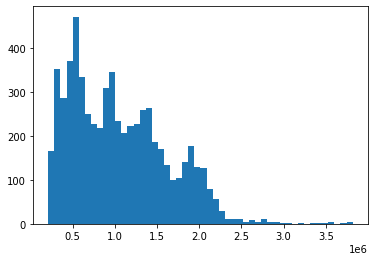

In [18]:
# 이번엔 예측하고자 하는 값인 Weekly_Sales를 확인해봅니다.
plt.hist(train.Weekly_Sales, bins=50)
plt.show()

# II. 데이터 전처리

### 1. 결측치(NA) 처리

결측치란 관측되지 않아 아무것도 없는 공간(Not Available)으로 되어있는 데이터입니다.

이 부분을 무엇인가로 채워주어야 분석을 진행할 수 있습니다.

이번에는 간단하게 숫자 0 으로 빈 부분을 채워주겠습니다.

In [19]:
# pandas의 fillna(0) 메소드를 활용합니다.
train = train.fillna(0)

# 결과를 확인합니다.
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


### 2. Date 전처리

Date 칼럼은 날짜 정보를 담고 있습니다.

날짜는 겉으로 보기엔 숫자로 이루어져 있는 것 같지만  
위의 출력 결과에서 볼 수 있다 시피 "31/08/2012" 형태의 문자로 이루어져 있습니다.

따라서 Date컬럼을 년/월/일로 일주일단위로 변경하려고 합니다

In [20]:
# Date 칼럼에서 "년/월/일자" 형태로 반환하는 함수를 작성합니다.
def get_date(date):
    year = str(date[6:])
    month = str(date[3:5])
    day = str(date[0:2])
    return year + month + day

# 이 함수를 Date 칼럼에 적용한 Month 칼럼을 만들어줍니다.
train['Date'] = train['Date'].apply(get_date)

# 결과를 확인합니다.
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,20100205,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90
1,2,1,20100212,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44
2,3,1,20100219,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17
3,4,1,20100226,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59
4,5,1,20100305,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,20120831,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,20120907,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,20120914,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,20120921,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


In [21]:
#date컬럼에서 str를 datetime으로 변경
train['Date'] = pd.to_datetime(train['Date'])
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90
1,2,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44
2,3,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17
3,4,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59
4,5,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,2012-08-31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,2012-09-07,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,2012-09-14,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,2012-09-21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


In [22]:
#train컬럼 타입 재확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            6255 non-null   int64         
 1   Store         6255 non-null   int64         
 2   Date          6255 non-null   datetime64[ns]
 3   Temperature   6255 non-null   float64       
 4   Fuel_Price    6255 non-null   float64       
 5   Promotion1    6255 non-null   float64       
 6   Promotion2    6255 non-null   float64       
 7   Promotion3    6255 non-null   float64       
 8   Promotion4    6255 non-null   float64       
 9   Promotion5    6255 non-null   float64       
 10  Unemployment  6255 non-null   float64       
 11  IsHoliday     6255 non-null   bool          
 12  Weekly_Sales  6255 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2)
memory usage: 592.6 KB


### 3. IsHoliday 전처리

Date 칼럼은 휴일 정보를 담고 있습니다.

값은 휴일인 경우 True , 휴일이 아닌 경우 False 값을 갖습니다.

파이썬에서는 True 는 1로, False는 0으로 해석하기 때문에 굳이 전처리를 해주지 않아도 분석을 진행하는 데에는 문제가 없습니다.

하지만 공부하는 겸 전처리를 해보도록 하죠!

In [23]:
# IsHoliday 칼럼의 값을 숫자 형태로 반환하는 함수를 작성합니다.
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number

# 이 함수를 IsHoliday 칼럼에 적용한 NumberHoliday 칼럼을 만들어줍니다.
train['NumberHoliday'] = train['IsHoliday'].apply(holiday_to_number)

# 결과를 확인합니다.
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,NumberHoliday
0,1,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90,0
1,2,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44,1
2,3,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17,0
3,4,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59,0
4,5,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,2012-08-31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87,0
6251,6252,45,2012-09-07,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66,1
6252,6253,45,2012-09-14,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27,0
6253,6254,45,2012-09-21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20,0


In [24]:
# test파일도 똑같이 전처리해 주어야함
# 결측치 처리
test = test.fillna(0)

# Date 전처리
test['Date'] = test['Date'].apply(get_date)
test['Date'] = pd.to_datetime(test['Date'])

# IsHoliday 전처리
test['NumberHoliday'] = test['IsHoliday'].apply(holiday_to_number)
test

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,NumberHoliday
0,1,1,2012-10-05,68.55,3.617,8077.89,0.00,18.22,3617.43,3626.14,6.573,False,0
1,2,1,2012-10-12,62.99,3.601,2086.18,0.00,8.11,602.36,5926.45,6.573,False,0
2,3,1,2012-10-19,67.97,3.594,950.33,0.00,4.93,80.25,2312.85,6.573,False,0
3,4,1,2012-10-26,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False,0
4,5,2,2012-10-05,70.27,3.617,6037.76,0.00,10.04,3027.37,3853.40,6.170,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,44,2012-10-26,46.97,3.755,38.65,2.61,0.98,0.00,457.74,5.217,False,0
176,177,45,2012-10-05,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,8.667,False,0
177,178,45,2012-10-12,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,8.667,False,0
178,179,45,2012-10-19,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,8.667,False,0


# III. Modeling

이제 전처리가 완료된 데이터를 사용하여 분석 모델을 학습시키고 예측 결과를 만들어보겠습니다.

### 1. Prophet 모델 적용시키기

Store별로 뽑아서 weekly_Sales를 예측해주려고합니다. -> 그냥 돌리면 날짜가 겹치는 부분이 있어서 이상하게 학습함

-> **Parameter 설명**
* changepoints : 	트렌드 변화시점을 명시한 리스트값
* changepoint_prior_scale :	changepoint(trend) 의 유연성 조절
* n_changepoints : changepoint 의 개수
* changepoint_range	changepoint : 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)
* yearly_seasonality: 연 계절성
* weekly_seasonality :주 계절성
* daily_seasonality	: 일 계절성
* seasonality_prior_scale	: 계절성 반영 강도
* seasonality_mode : ‘additive ‘ 인지 ‘multiplicative’ 인지
* holidays : 휴일 또는 이벤트 기간을 명시한 데이터프레임
* holiday_prior_scale	holiday : 반영 강도

In [25]:
#prophet 모듈 다운
!pip install pystan==2.19.1.1
!pip install fbprophet==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 166 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.7 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7-py3-none-any.whl size=6638475 sha256=fc0dd3c4c7de7df0041f65c2ffcf87b78efa8304036c90ca6ce6dee07e3e094f
  Stored in directory: /root/.cache/pip/wheels/82/e8/a8/53f37f0a409bc51f8693e967dcce8f88bfd33632b40a594a28
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.4
    Uninstalling cmdstanpy-1.0.4:
      Successfully uninstalled cmdstanpy-1.0.4
ERROR: pip's dependency resolver does not currently take into account all the pa

In [26]:
#prophet 모듈
from fbprophet import Prophet

In [ ]:
# #Store 별로 Prophet모델을 학습시켜 예측
# #ds,y형태의 데이터프레임 만들기
# df = pd.DataFrame()
# pred_list = []
# rmse = []

# for i in range(1,46):
#   df['ds'] = train[train["Store"] == i]['Date'].reset_index(drop=True)
#   df['y'] = train[train["Store"] == i]['Weekly_Sales'].reset_index(drop=True)

#   model = Prophet(yearly_seasonality=20)
#   model.fit(df)

#   df_pred = model.make_future_dataframe(periods=5, freq='w')
#   predict = model.predict(df_pred)

#   #140번째부터 일주일씩 예측한 것 pred_list에 추가하기
#   pred_list.extend(predict['yhat'][140:])
#   #기존 값에 rmse를 구한 list
#   rmse.append(mean_squared_error(list(df['y']), list(predict['yhat'][:139]))**0.5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
predict.tail(10)

In [ ]:
#Store별로 예측한 것을 sample_submission에 복사
sample_submission['Weekly_Sales'] = pd.Series(pred_list)

In [ ]:
#train data rmse 평균값
np.mean(rmse)

58425.621194835214

58425.621194835214

In [ ]:
rmse

[68842.58748067403,
 97225.56701326444,
 18157.259068948755,
 102840.338859892,
 15984.73873161851,
 79602.53702677753,
 35437.97027661461,
 43089.5007194115,
 26875.114778786534,
 111038.12774195902,
 65914.77141872849,
 56628.067168350404,
 108886.75917347653,
 149718.81713296214,
 46139.388005549314,
 27836.837569498213,
 57987.36181347798,
 78290.92183517714,
 81220.86968764458,
 118528.32398972423,
 48885.6861821417,
 63965.1236848108,
 94409.20258267337,
 76556.86440521128,
 38171.81581369917,
 49842.579803417364,
 109444.35055877909,
 94017.44652782854,
 40408.48662252256,
 13629.779706709498,
 56682.41795941237,
 57124.454205667746,
 9113.79166619838,
 46210.19281318107,
 82954.61087521544,
 11333.302900079494,
 13030.745305474815,
 15728.18001482836,
 81532.55367746585,
 55823.00792808155,
 74941.49287503332,
 16637.914131924776,
 24606.35939089948,
 10252.15682036622,
 53604.57782342579]

### Prophet 기본 모델 시각화

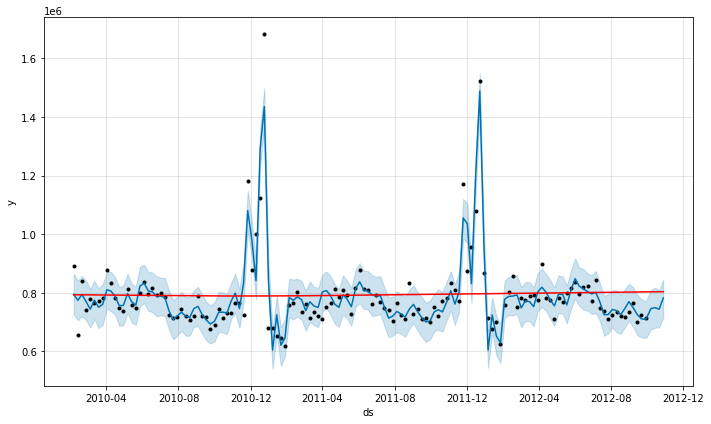

In [ ]:
#Trend 확인
#빨간점 : 추세선, 검은점 : 실제값
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(predict)
a = add_changepoints_to_plot(fig.gca(), model, predict)

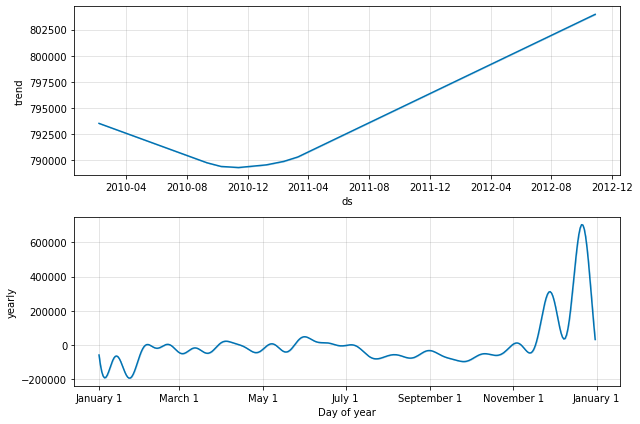

In [ ]:
#모델의 컴포턴트 시각화
# trend : 추세성, weekly : 주 계절성, daily : 일 계절성, yearly : 연 계절성
fig2 = model.plot_components(predict)

In [ ]:
train[train['NumberHoliday'] == 1].reset_index(drop=True)['Date']

0     2010-02-12
1     2010-09-10
2     2010-11-26
3     2010-12-31
4     2011-02-11
         ...    
445   2011-09-09
446   2011-11-25
447   2011-12-30
448   2012-02-10
449   2012-09-07
Name: Date, Length: 450, dtype: datetime64[ns]

In [28]:
#holiday 설정
holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.Series(train[train['NumberHoliday'] == 1].reset_index(drop=True)['Date'])
    # lower_window = 0,
    # upper_window = 1
})
holiday = holiday.reset_index(drop=True)
holiday

,holiday,ds
0,holiday,2010-02-12
1,holiday,2010-09-10
2,holiday,2010-11-26
3,holiday,2010-12-31
4,holiday,2011-02-11
...,...,...
445,holiday,2011-09-09
446,holiday,2011-11-25
447,holiday,2011-12-30
448,holiday,2012-02-10


In [29]:
#Store 별로 Prophet모델을 학습시켜 예측
#ds,y형태의 데이터프레임 만들기
df2 = pd.DataFrame()
pred_list2 = []
rmse2 = []

for i in range(1,46):
  df2['ds'] = train[train["Store"] == i]['Date'].reset_index(drop=True)
  df2['y'] = train[train["Store"] == i]['Weekly_Sales'].reset_index(drop=True)

  model2 = Prophet(yearly_seasonality=30,
                   holidays=holiday,
                   holidays_prior_scale=10
                   )
  model2.fit(df2)

  df_pred2 = model2.make_future_dataframe(periods=5, freq='w')
  predict2 = model2.predict(df_pred2)

  #140번째부터 일주일씩 예측한 것 pred_list에 추가하기
  pred_list2.extend(predict2['yhat'][139:143])
  #기존 값에 rmse를 구한 list
  rmse2.append(mean_squared_error(list(df2['y']), list(predict2['yhat'][:139]))**0.5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [30]:
#train data rmse 평균값
np.mean(rmse2)

29077.69428949089

In [31]:
rmse2

[33572.76895566892,
 38715.52120543947,
 12139.602766036549,
 39547.08941444257,
 7964.7700064750115,
 36631.14717914533,
 19814.49943989405,
 18085.66945471383,
 12939.461884345012,
 49706.07685852294,
 33068.28044750451,
 24853.841219165522,
 47489.23149236571,
 82317.2412578639,
 23134.95684177378,
 14294.36252386182,
 24784.828018728687,
 49383.44573981603,
 40980.61959689568,
 67162.43337097841,
 26063.12109968802,
 32226.02841498877,
 57996.54723704996,
 41042.4590356813,
 20608.007179420194,
 21956.722631660272,
 67065.00680374047,
 47890.56624101339,
 21100.395374590673,
 10178.374384991743,
 22313.853701412285,
 22203.94201412272,
 6718.673101977813,
 17210.565646018425,
 46110.925368903765,
 9618.837452426607,
 8232.405346959551,
 9453.280071964535,
 36729.52780975773,
 23321.53679344942,
 25991.488917174007,
 9401.910939228654,
 16560.608306760292,
 6072.223324443077,
 25843.38815602862]

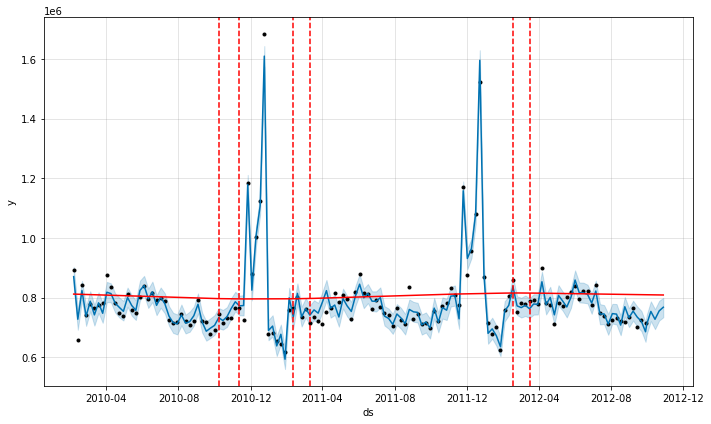

In [32]:
from fbprophet.plot import add_changepoints_to_plot
fig = model2.plot(predict2)
b = add_changepoints_to_plot(fig.gca(), model2, predict2)

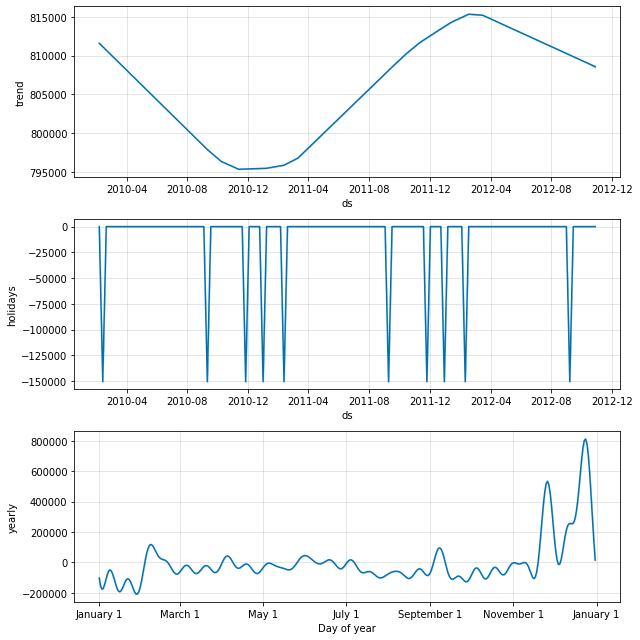

In [33]:
fig2 = model2.plot_components(predict2)

In [34]:
predict2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holiday,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,811591.110413,837600.550885,902840.207797,811591.110413,811591.110413,58530.731899,58530.731899,58530.731899,0.000000,...,0.000000,0.000000,0.000000,58530.731899,58530.731899,58530.731899,0.0,0.0,0.0,870121.842312
1,2010-02-12,811149.978135,692083.067277,759562.591750,811149.978135,811149.978135,-83827.909563,-83827.909563,-83827.909563,-150580.133229,...,-150580.133229,-150580.133229,-150580.133229,66752.223666,66752.223666,66752.223666,0.0,0.0,0.0,727322.068571
2,2010-02-19,810708.845856,792893.643217,855944.210471,810708.845856,810708.845856,12746.386623,12746.386623,12746.386623,0.000000,...,0.000000,0.000000,0.000000,12746.386623,12746.386623,12746.386623,0.0,0.0,0.0,823455.232480
3,2010-02-26,810267.713578,704965.760402,770547.002995,810267.713578,810267.713578,-72910.623346,-72910.623346,-72910.623346,0.000000,...,0.000000,0.000000,0.000000,-72910.623346,-72910.623346,-72910.623346,0.0,0.0,0.0,737357.090232
4,2010-03-05,809826.581299,753823.124839,821282.532113,809826.581299,809826.581299,-22219.923295,-22219.923295,-22219.923295,0.000000,...,0.000000,0.000000,0.000000,-22219.923295,-22219.923295,-22219.923295,0.0,0.0,0.0,787606.658004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2012-09-30,809404.850296,676951.199069,741844.824054,809404.850296,809404.850296,-99152.780016,-99152.780016,-99152.780016,0.000000,...,0.000000,0.000000,0.000000,-99152.780016,-99152.780016,-99152.780016,0.0,0.0,0.0,710252.070280
140,2012-10-07,809199.814929,721122.388306,787338.744298,809199.148569,809200.093763,-55723.150590,-55723.150590,-55723.150590,0.000000,...,0.000000,0.000000,0.000000,-55723.150590,-55723.150590,-55723.150590,0.0,0.0,0.0,753476.664339
141,2012-10-14,808994.779562,693970.845717,760900.761722,808965.378207,809030.373722,-81789.548350,-81789.548350,-81789.548350,0.000000,...,0.000000,0.000000,0.000000,-81789.548350,-81789.548350,-81789.548350,0.0,0.0,0.0,727205.231212
142,2012-10-21,808789.744195,722945.423399,788994.753216,808716.142639,808865.722196,-53683.261182,-53683.261182,-53683.261182,0.000000,...,0.000000,0.000000,0.000000,-53683.261182,-53683.261182,-53683.261182,0.0,0.0,0.0,755106.483013


In [35]:
#Store별로 예측한 것을 sample_submission에 복사
sample_submission['Weekly_Sales'] = pd.Series(pred_list2)

In [36]:
# submission을 csv 파일로 저장합니다.
# index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다. 
# 정확한 채점을 위해 꼭 index=False를 넣어주세요.
sample_submission.to_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/submission14.csv',index = False)

# IV. 앙상블

In [ ]:
#prophet_파라미터(yearly_seasonality=30, holiday=10)
df1 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/submission11.csv')
df1

#prophet_파라미터(voting1)
df2 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/voting_1.csv')
df2

# #prophet_파라미터(연계절성=30)
df3 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/submission8.csv')
df3

,id,Weekly_Sales
0,1,1.650406e+06
1,2,1.562593e+06
2,3,1.501195e+06
3,4,1.505032e+06
4,5,1.912969e+06
...,...,...
175,176,3.438207e+05
176,177,7.526160e+05
177,178,7.254256e+05
178,179,7.556717e+05


In [ ]:
#prophet_파라미터(연계절성=30, holiday=10)
df1 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/submission11.csv')
df1

# #prophet_파라미터(연계절성=30)
df2 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/submission8.csv')
df2

,id,Weekly_Sales
0,1,1.650406e+06
1,2,1.562593e+06
2,3,1.501195e+06
3,4,1.505032e+06
4,5,1.912969e+06
...,...,...
175,176,3.438207e+05
176,177,7.526160e+05
177,178,7.254256e+05
178,179,7.556717e+05


In [ ]:
#prophet_파라미터(연계절성=30, holiday=10)
df1 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/voting_1.csv')
df1

# #prophet_파라미터(연계절성=30)
df2 = pd.read_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/voting_2.csv')
df2

,id,Weekly_Sales
0,1,1.648618e+06
1,2,1.567003e+06
2,3,1.497207e+06
3,4,1.509530e+06
4,5,1.909444e+06
...,...,...
175,176,3.437770e+05
176,177,7.522854e+05
177,178,7.288867e+05
178,179,7.541759e+05


In [ ]:
answer = []
for i in range(len(df1)):
  # nums = (df1['Weekly_Sales'][i]+df2['Weekly_Sales'][i]+df3['Weekly_Sales'][i])/ 3
  nums = (df1['Weekly_Sales'][i]+df2['Weekly_Sales'][i])/ 2
  answer.append(nums)

In [ ]:
Id = []
for i in range(len(df1)):
  Id.append(df1["id"][i])

In [ ]:
df_mean = pd.DataFrame({'id': Id, 'Weekly_Sales': answer})
df_mean

,id,Weekly_Sales
0,1,1.646967e+06
1,2,1.571386e+06
2,3,1.493708e+06
3,4,1.513853e+06
4,5,1.905512e+06
...,...,...
175,176,3.435015e+05
176,177,7.515245e+05
177,178,7.314580e+05
178,179,7.529628e+05


In [ ]:
# voting한 것 저장
df_mean.to_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 쇼핑몰 지점별 매출액 예측 경진대회/data/voting_4.csv', index=False)